# Set Up Feature Store

## Import libraries

In [2]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sagemaker
import seaborn as sns
import time
import warnings

from IPython.core.display import HTML
from pandas.api.types import CategoricalDtype
from pyathena import connect
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from sklearn.impute import SimpleImputer

# suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# filter out the specific UserWarning related to DBAPI2 objects
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable")

In [3]:
# check stored variables
%store

Stored variables and their in-db values:
bucket_name                            -> 'housing-dataset-5435'
set_up_dependencies_passed             -> True
set_up_s3_bucket_passed                -> True


## Pull Data from Athena

In [4]:
# save Amazon information
account_id = boto3.client("sts").get_caller_identity().get("Account")
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3', region_name=sagemaker_session.boto_region_name)

In [5]:
# get bucket_name
%store -r bucket_name
print(bucket_name)

# set S3 staging directory
s3_staging_dir = "s3://{0}/athena/staging".format(bucket_name)

# create connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

housing-dataset-5435


In [6]:
# set database name and table name
database_name = "housing"
table_name = "data"

# pull data
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)
df = pd.read_sql(statement, conn)
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,,Reg,Lvl,AllPub,...,0,,,,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,,Reg,Lvl,AllPub,...,0,,,,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,,IR1,Lvl,AllPub,...,0,,,,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,,IR1,Lvl,AllPub,...,0,,,,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,,IR1,Lvl,AllPub,...,0,,,,0,12,2008,WD,Normal,250000.0


## Data Processing

In [7]:
# drop numerical feature with a lot of missing values
df = df.drop('lotfrontage', axis=1)

# drop categorical features with a lot of missing values
df = df.drop('fireplacequ', axis=1)
df = df.drop('fence', axis=1)
df = df.drop('alley', axis=1)
df = df.drop('miscfeature', axis=1)
df = df.drop('poolqc', axis=1)

In [8]:
# the nominal categorical features
features_nom = ["mssubclass", "mszoning", "street", "landcontour",
                "lotconfig", "neighborhood", "condition1", "condition2",
                "bldgtype", "housestyle", "roofstyle", "roofmatl", "exterior1st",
                "exterior2nd", "masvnrtype", "foundation", "heating", "centralair",
                "garagetype", "saletype", "salecondition"]

# the ordinal (ordered) categorical features
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))
ordered_levels = {
    "overallqual": ten_levels,
    "overallcond": ten_levels,
    "exterqual": five_levels,
    "extercond": five_levels,
    "bsmtqual": five_levels,
    "bsmtcond": five_levels,
    "heatingqc": five_levels,
    "kitchenqual": five_levels,
    "garagequal": five_levels,
    "garagecond": five_levels,
    "lotshape": ["Reg", "IR1", "IR2", "IR3"],
    "landslope": ["Sev", "Mod", "Gtl"],
    "bsmtexposure": ["No", "Mn", "Av", "Gd"],
    "bsmtfintype1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "bsmtfintype2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "garagefinish": ["Unf", "RFn", "Fin"],
    "paveddrive": ["N", "P", "Y"],
    "utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "centralair": ["N", "Y"],
    "electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"]
}

# nominal categories
for name in features_nom:
    df[name] = df[name].astype("category")

# ordinal categories
for name, levels in ordered_levels.items():
    df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))

# assign the code to the categories
for name in ordered_levels.keys():
    df[name] = df[name].cat.codes

## Feature Engineering

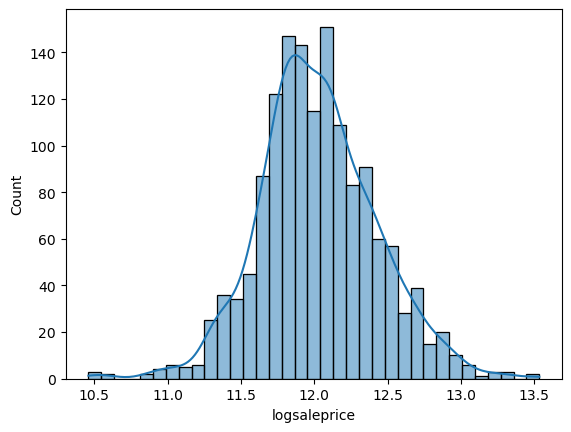

In [10]:
# Apply log transformation
df['logsaleprice'] = np.log(df['saleprice'])

# Plot histogram to see the new distribution
sns.histplot(df['logsaleprice'], kde=True)
plt.show()

In [11]:
# function to one hot encode categorical columns
def one_hot_encode_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    return df_encoded

# perform the one-hot encode on categorical  columns
df_encoded = one_hot_encode_categorical_columns(df)

# Convert int8 columns to integer type
int8_columns = df_encoded.select_dtypes(include=['int8']).columns.tolist()
df_encoded[int8_columns] = df_encoded[int8_columns].astype(int)

# Convert uint8 columns to integer type
uint8_columns = df_encoded.select_dtypes(include=['uint8']).columns.tolist()
df_encoded[uint8_columns] = df_encoded[uint8_columns].astype(int)

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 231 entries, id to salecondition_Partial
dtypes: float64(12), int64(219)
memory usage: 5.1 MB
None


In [12]:
# Impute missing values for numerical columns with median
numerical_columns = df_encoded.select_dtypes(include=[float, int]).columns.tolist()
numerical_imputer = SimpleImputer(strategy='median')
df_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(df_encoded[numerical_columns]), columns=numerical_columns)

# Create new imputed dataset
df_imputed = pd.concat([df_numerical_imputed], axis=1)
shape = df_imputed.shape
print("Shape of the dataframe (row, col):",shape,"\r\n")
df_imputed.head(5)

Shape of the dataframe (row, col): (2919, 231) 



,id,lotarea,lotshape,utilities,landslope,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1.0,8450.0,0.0,2.0,2.0,7.0,5.0,2003.0,2003.0,196.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,9600.0,0.0,2.0,2.0,6.0,8.0,1976.0,1976.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,11250.0,1.0,2.0,2.0,7.0,5.0,2001.0,2002.0,162.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,9550.0,1.0,2.0,2.0,7.0,5.0,1915.0,1970.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,14260.0,1.0,2.0,2.0,8.0,5.0,2000.0,2000.0,350.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Prepare Data for Feature Store

In [13]:
# add an event time
df_imputed['event_time'] = pd.Timestamp.now()
df_imputed.head(5)

,id,lotarea,lotshape,utilities,landslope,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,...,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,event_time
0,1.0,8450.0,0.0,2.0,2.0,7.0,5.0,2003.0,2003.0,196.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2024-06-11 04:29:24.102974
1,2.0,9600.0,0.0,2.0,2.0,6.0,8.0,1976.0,1976.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2024-06-11 04:29:24.102974
2,3.0,11250.0,1.0,2.0,2.0,7.0,5.0,2001.0,2002.0,162.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2024-06-11 04:29:24.102974
3,4.0,9550.0,1.0,2.0,2.0,7.0,5.0,1915.0,1970.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2024-06-11 04:29:24.102974
4,5.0,14260.0,1.0,2.0,2.0,8.0,5.0,2000.0,2000.0,350.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2024-06-11 04:29:24.102974


In [14]:
# check column types
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 232 entries, id to event_time
dtypes: datetime64[ns](1), float64(231)
memory usage: 5.2 MB
None


In [15]:
# convert datetime to Unix timestamp (seconds since epoch)
df_imputed['event_time'] = df_imputed['event_time'].astype(int) / 10**9

In [16]:
# clean column names
def clean_feature_name(feature_name):
    # Replace invalid characters with underscores
    cleaned_name = re.sub(r'[^a-zA-Z0-9_-]', '_', feature_name)
    # Ensure the name does not start or end with an underscore or hyphen
    cleaned_name = re.sub(r'^[_-]+|[_-]+$', '', cleaned_name)
    return cleaned_name

# Apply the cleaning function to the column names
cleaned_columns = [clean_feature_name(col) for col in df_imputed.columns]
df_imputed.columns = cleaned_columns

## Set Up Feature Store

In [17]:
# set up Feature Store Session with AWS
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)
feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

In [18]:
# define feature group name
feature_group_name = "housing"

# define feature group
feature_group = FeatureGroup(
    name=feature_group_name, sagemaker_session=feature_store_session
)

# load feature definitions to the feature group
feature_group.load_feature_definitions(data_frame=df_imputed)

[FeatureDefinition(feature_name='id', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='lotarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='lotshape', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='utilities', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='landslope', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='overallqual', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='overallcond', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='yearbuilt', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='yearremodadd', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>),
 FeatureDefinition(feature_name='masvnrarea', feature_type=<FeatureTypeEnum.

In [19]:
# create feature groups in feature store
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


# record identifier and event time feature names
record_identifier_feature_name = "id"
event_time_feature_name = "event_time"    
prefix = "feature_store"

feature_group.create(
    s3_uri=f"s3://{bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=feature_group)

ResourceInUse: An error occurred (ResourceInUse) when calling the CreateFeatureGroup operation: Resource Already Exists: FeatureGroup with name housing already exists. Choose a different name.

In [ ]:
# check that the feature group exists
feature_group.describe()

## Ingest Data into Feature Store

In [ ]:
# ingest data
feature_group.ingest(data_frame=df_imputed, max_workers=3, wait=True)

In [ ]:
# test it works
featurestore_runtime.get_record(
    FeatureGroupName=feature_group_name,
    RecordIdentifierValueAsString="1.0",
)

## Shut down notebook resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}